In [1]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import contextily as ctx
import jenkspy

### shape file of highland postcode

#### point

In [2]:
shapefile = gpd.read_file("highland.shp")
shapefile.explore()

DriverError: highland.shp: No such file or directory

In [22]:
boolean = shapefile.duplicated(subset=['postcode']).any()
print(boolean, end='\n\n') # True

False



#### polygon

In [14]:
postcode_polygon_uk = gpd.read_file("../../Data/Data processing/Social-demongraphic/census2011_shp/postcode-2011-eor/Postcode2011_EoR.shp")
postcode_polygon_highland = postcode_polygon_uk.loc[postcode_polygon_uk.council == 'S12000017']
#postcode_polygon_highland.to_file('data/postcode_shp/highland_polygon.shp', driver='ESRI Shapefile')

In [24]:
postcode_polygon_highland = gpd.read_file("data/postcode_shp/highland_polygon.shp")

In [9]:
postcode_polygon_highland.explore("Popcount", cmap="Reds", scheme='naturalbreaks', tiles='cartodbpositron',style_kwds=dict(stroke=True, color="black",weight=1, opacity=0.4, fillOpacity=1))

#### travel time 

In [28]:
postcode_polygon_highland = gpd.read_file('data/postcode_shp/highland_polygon.shp')
travel_time = pd.read_csv('travel_time_matrix.csv')
travel_time_2 = pd.read_csv('travel_time_matrix_unmatched.csv')

In [62]:
travel_time_2

origin_postcode destination_postcode  travel_time  time_minute
0          IV2 3ES              IV2 7JB         2373    39.550000
1         IV55 8GF              IV2 7JB        19101   318.350000
2         IV51 9QN              IV2 7JB        18543   309.050000
3         PH33 7AS              IV2 7JB        12200   203.333333
4        PH44 4RSB              IV2 7JB        73528  1225.466667
..             ...                  ...          ...          ...
64        IV25 3PP              IV2 7JB         9520   158.666667
65         KW1 4AF              IV2 7JB        14414   240.233333
66        KW14 8TW              IV2 7JB        16447   274.116667
67        IV20 1WP              IV2 7JB        34209   570.150000
68        KW12 6XQ              IV2 7JB        49152   819.200000

[69 rows x 4 columns]

In [54]:
combined_travel_time = pd.concat([travel_time, travel_time_2], ignore_index=True)

In [60]:
postcode_polygon_highland['postcode'] = postcode_polygon_highland['postcode'].astype(str)
combined_travel_time['origin_postcode'] = combined_travel_time['origin_postcode'].astype(str)

postcodes_highland = set(postcode_polygon_highland['postcode'])
postcodes_combined = set(combined_travel_time['origin_postcode'])

unmatched_postcodes = postcodes_highland - postcodes_combined

In [65]:
merged_gdf = postcode_polygon_highland.merge(combined_travel_time, left_on='postcode', right_on='origin_postcode', how='left')

In [10]:
merged_gdf.explore("time_minute", cmap='Blues_r', 
                   scheme='naturalbreaks', tiles='cartodbpositron',
                   style_kwds=dict(stroke=True, color="#D3D3D3", weight=1, opacity=0.4, fillOpacity=1),
                   nan_color='transparent')


### All travel time

In [4]:
postcode_polygon_highland = gpd.read_file('data/postcode_shp/highland_polygon.shp')
railway_highland = gpd.read_file("data/UK_railways/UK_Railways/Railway_highland.shp")
railway_station_highland = gpd.read_file("data/UK_railways/UK_Railways/Railway_Station_highland.shp")

airport = pd.read_csv('data/travel_time_0725/airport_alltime.csv')
campus = pd.read_csv('data/travel_time_0725/campus_health_research_alltime.csv')
hospital = pd.read_csv('data/travel_time_0725/hospital_alltime.csv')
shopping = pd.read_csv('data/travel_time_0725/shopping_mall_alltime.csv')
airport_station = pd.read_csv('data/travel_time_0725/train_station_time.csv')

In [29]:
airport.departure_time.unique()

array(['2024-07-17 08:00:00', '2024-07-17 12:00:00',
       '2024-07-17 17:00:00'], dtype=object)

In [30]:
def prepare_df(df):
    df['walk_time_percentage'] = df['walk_time_minute']/df['total_time_minute']
    
    df1 = df.loc[df.departure_time == '2024-07-17 08:00:00']
    df2 = df.loc[df.departure_time == '2024-07-17 12:00:00']
    df3 = df.loc[df.departure_time == '2024-07-17 17:00:00']
    
    df1_polygon = postcode_polygon_highland.merge(df1, left_on='postcode', right_on='origin_postcode', how='left')
    df2_polygon = postcode_polygon_highland.merge(df2, left_on='postcode', right_on='origin_postcode', how='left')
    df3_polygon = postcode_polygon_highland.merge(df3, left_on='postcode', right_on='origin_postcode', how='left')
    
    return df1_polygon, df2_polygon, df3_polygon

In [31]:
airport1,airport2,airport3 = prepare_df(airport)
campus1,campus2,campus3 = prepare_df(campus)
hospital1,hospital2,hospital3 = prepare_df(hospital)
shopping1,shopping2,shopping3 = prepare_df(shopping)
airport_station1,airport_station2,airport_station3 = prepare_df(airport_station)

In [32]:
def get_var_name(var, scope):
    # Iterate through the scope dictionary
    for name, value in scope.items():
        if value is var:
            return name
    return None

def make_map(df):
    df_name = get_var_name(df, globals())
    if df_name[-1] == '1':
        time = 'morning'
    elif df_name[-1] == '2':
        time = 'noon'
    else:
        time = 'evening'
    place = df_name[0:-1]
    
    m = df.explore(column = "total_time_minute", cmap='Blues', 
                         tooltip=['postcode','departure_time','total_time_minute'],
                         scheme='naturalbreaks', #tiles='cartodbpositron',
                         style_kwds=dict(stroke=True, color="#D3D3D3", weight=1, opacity=0.4, fillOpacity=1),
                         legend_kwds=dict(caption=place+' '+time+' total time'),
                         name=place+' '+time+' total time')
    m = df.explore(m=m,column = "walk_time_percentage", cmap='Reds', 
                         scheme='naturalbreaks', #tiles='cartodbpositron',
                         tooltip=['postcode','departure_time','walk_time_minute','walk_time_percentage'],
                         style_kwds=dict(stroke=True, color="#D3D3D3", weight=1, opacity=0.4, fillOpacity=1),
                         legend_kwds=dict(caption=place+' '+time+' walking time percentage'),
                         name=place+' '+time+' walking time percentage')
    m = railway_highland.explore(m=m,tooltip=['LEGEND','NUMBER'],color='black',name="train line")
    m = railway_station_highland.explore(m=m, tooltip=['NAME','NUMBER'],color='red',name="train staion")

    # this is completely optional
    folium.LayerControl().add_to(m)  
    m.save(place+'_'+time+'.html')

In [33]:
place_list = [airport1,airport2,airport3,campus1,campus2,campus3,hospital1,hospital2,hospital3,shopping1,shopping2,shopping3,airport_station1,airport_station2,airport_station3]

In [34]:
for i in place_list:
    #print(i)
    make_map(i)

### All travel time 2

In [6]:
airport_new = pd.read_pickle('data/0801_trave_iternary/0801_itenerary_airport.pkl')
station_new = pd.read_pickle('data/0801_trave_iternary/0801_itenerary_station.pkl')
campus_new = pd.read_pickle('data/0801_trave_iternary/0801_itenerary_campus.pkl')
hospital_new = pd.read_pickle('data/0801_trave_iternary/0801_itenerary_hospital.pkl')
shop_new = pd.read_pickle('data/0801_trave_iternary/0801_itenerary_shop.pkl')

In [7]:
hospital_new.departure_time.unique()

array(['2024-08-01 09:00:00', '2024-08-01 12:00:00',
       '2024-08-01 17:00:00'], dtype=object)

In [8]:
airport_new.departure_time.unique()

array(['2024-08-01 09:00:00', '2024-08-01 17:00:00',
       '2024-08-01 20:00:00'], dtype=object)

In [9]:
station_new.departure_time.unique()

array(['2024-08-01 09:00:00', '2024-08-01 17:00:00',
       '2024-08-01 20:00:00'], dtype=object)

In [87]:
campus_new.departure_time.unique()

array(['2024-08-01 08:00:00', '2024-08-01 12:00:00',
       '2024-08-01 17:00:00'], dtype=object)

In [88]:
shop_new.departure_time.unique()

array(['2024-08-01 08:00:00', '2024-08-01 12:00:00',
       '2024-08-01 17:00:00'], dtype=object)

In [10]:
hospital_new

origin_postcode destination_postcode  \
0            AB37 9HR              IV2 3UJ   
1             KW1 4AA              IV2 3UJ   
2             KW1 4AB              IV2 3UJ   
3             KW1 4AG              IV2 3UJ   
4             KW1 4AH              IV2 3UJ   
...               ...                  ...   
21852        PA80 5XS              IV2 3UJ   
21853        PA80 5XT              IV2 3UJ   
21854        PA80 5XW              IV2 3UJ   
21855        PA80 5XY              IV2 3UJ   
21856        PA80 5XZ              IV2 3UJ   

                                                 summary  \
0      [(WALKING, 27), (TRANSIT (BUS) 364, 17), (WALK...   
1      [(WALKING, 4), (TRANSIT (BUS) X99, 175), (WALK...   
2      [(WALKING, 2), (TRANSIT (BUS) X99, 175), (WALK...   
3      [(WALKING, 1), (TRANSIT (BUS) X99, 175), (WALK...   
4      [(WALKING, 2), (TRANSIT (BUS) X99, 175), (WALK...   
...                                                  ...   
21852  [(WALKING, 10), (TRANSIT (BUS) 507, 82), (WALK...   
21853  [(WALKING, 3), (TRANSIT (BUS) 507, 79), (WALKI...   
21854  [(TRANSIT (BUS) 507, 79), (WALKING, 1), (TRANS...   
21855  [(WALKING, 11), (TRANSIT (BUS) 507, 103), (TRA...   
21856  [(WALKING, 28), (TRANSIT (BUS) 507, 103), (TRA...   

                                      detailed_itinerary  total_duration  \
0      [WALKING for 27, TRANSIT (BUS) 364 from Villag...             148   
1      [WALKING for 4, TRANSIT (BUS) X99 from Post Of...             199   
2      [WALKING for 2, TRANSIT (BUS) X99 from Post Of...             198   
3      [WALKING for 1, TRANSIT (BUS) X99 from Town Ha...             196   
4      [WALKING for 2, TRANSIT (BUS) X99 from Town Ha...             197   
...                                                  ...             ...   
21852  [WALKING for 10, TRANSIT (BUS) 507 from Pier t...             236   
21853  [WALKING for 3, TRANSIT (BUS) 507 from Drimnin...             226   
21854  [TRANSIT (BUS) 507 from Kirk Brae to Fort Will...             224   
21855  [WALKING for 11, TRANSIT (BUS) 507 from Slipwa...             261   
21856  [WALKING for 28, TRANSIT (BUS) 507 from Slipwa...             278   

       total_walking_time                               coordinates_by_stage  \
0                      43  [[(57.2782278, -3.4590352), (57.26821589999999...   
1                      13  [[(58.44527219999999, -3.094212), (58.445211, ...   
2                      12  [[(58.44261470000001, -3.0911123), (58.4426532...   
3                      11  [[(58.44173199999999, -3.09313), (58.441874299...   
4                      12  [[(58.4422972, -3.092176), (58.4424077, -3.092...   
...                   ...                                                ...   
21852                  18  [[(56.535187, -5.7805556), (56.5345274, -5.779...   
21853                  11  [[(56.53868929999999, -5.7790003), (56.5386932...   
21854                   8  [[(56.53901699999999, -5.781006), (56.820854, ...   
21855                  19  [[(56.6097299, -5.9770028), (56.610975, -5.976...   
21856                  35  [[(56.599007, -5.970375799999999), (56.6133444...   

            departure_time  origin_lat  origin_lon  destination_lat  \
0      2024-08-01 09:00:00   57.278146   -3.459058        57.473823   
1      2024-08-01 09:00:00   58.445390   -3.094151        57.473823   
2      2024-08-01 09:00:00   58.442425   -3.091078        57.473823   
3      2024-08-01 09:00:00   58.441834   -3.092944        57.473823   
4      2024-08-01 09:00:00   58.442245   -3.092117        57.473823   
...                    ...         ...         ...              ...   
21852  2024-08-01 17:00:00   56.535031   -5.780762        57.473823   
21853  2024-08-01 17:00:00   56.538731   -5.779146        57.473823   
21854  2024-08-01 17:00:00   56.538985   -5.781140        57.473823   
21855  2024-08-01 17:00:00   56.609761   -5.976860        57.473823   
21856  2024-08-01 17:00:00   56.599057   -5.970191        57.473823   

     

In [12]:
def prepare_df_2(df,time1,time2,time3):
    df['walk_time_percentage'] = df['total_walking_time']/df['total_duration']
    
    df1 = df.loc[df.departure_time == time1]
    df2 = df.loc[df.departure_time == time2]
    df3 = df.loc[df.departure_time == time3]
    
    df1_polygon = postcode_polygon_highland.merge(df1, left_on='postcode', right_on='origin_postcode', how='left')
    df2_polygon = postcode_polygon_highland.merge(df2, left_on='postcode', right_on='origin_postcode', how='left')
    df3_polygon = postcode_polygon_highland.merge(df3, left_on='postcode', right_on='origin_postcode', how='left')
    
    return df1_polygon, df2_polygon, df3_polygon

In [89]:
airport1,airport2,airport3 = prepare_df_2(airport_new,'2024-08-01 09:00:00','2024-08-01 17:00:00','2024-08-01 20:00:00')
campus1,campus2,campus3 = prepare_df_2(campus_new,'2024-08-01 08:00:00','2024-08-01 12:00:00','2024-08-01 17:00:00')
hospital1,hospital2,hospital3 = prepare_df_2(hospital_new,'2024-08-01 09:00:00','2024-08-01 12:00:00','2024-08-01 17:00:00')
shopping1,shopping2,shopping3 = prepare_df_2(shop_new,'2024-08-01 08:00:00','2024-08-01 12:00:00','2024-08-01 17:00:00')
airport_station1,airport_station2,airport_station3 = prepare_df_2(station_new,'2024-08-01 09:00:00','2024-08-01 17:00:00','2024-08-01 20:00:00')

In [95]:
maps = [hospital1,hospital2,hospital3]
times = ['Hospital 09:00:00','Hospital 12:00:00','Hospital 17:00:00']
bins = jenkspy.jenks_breaks(hospital_new['total_duration'],n_classes=5)[1:]

0
1
2


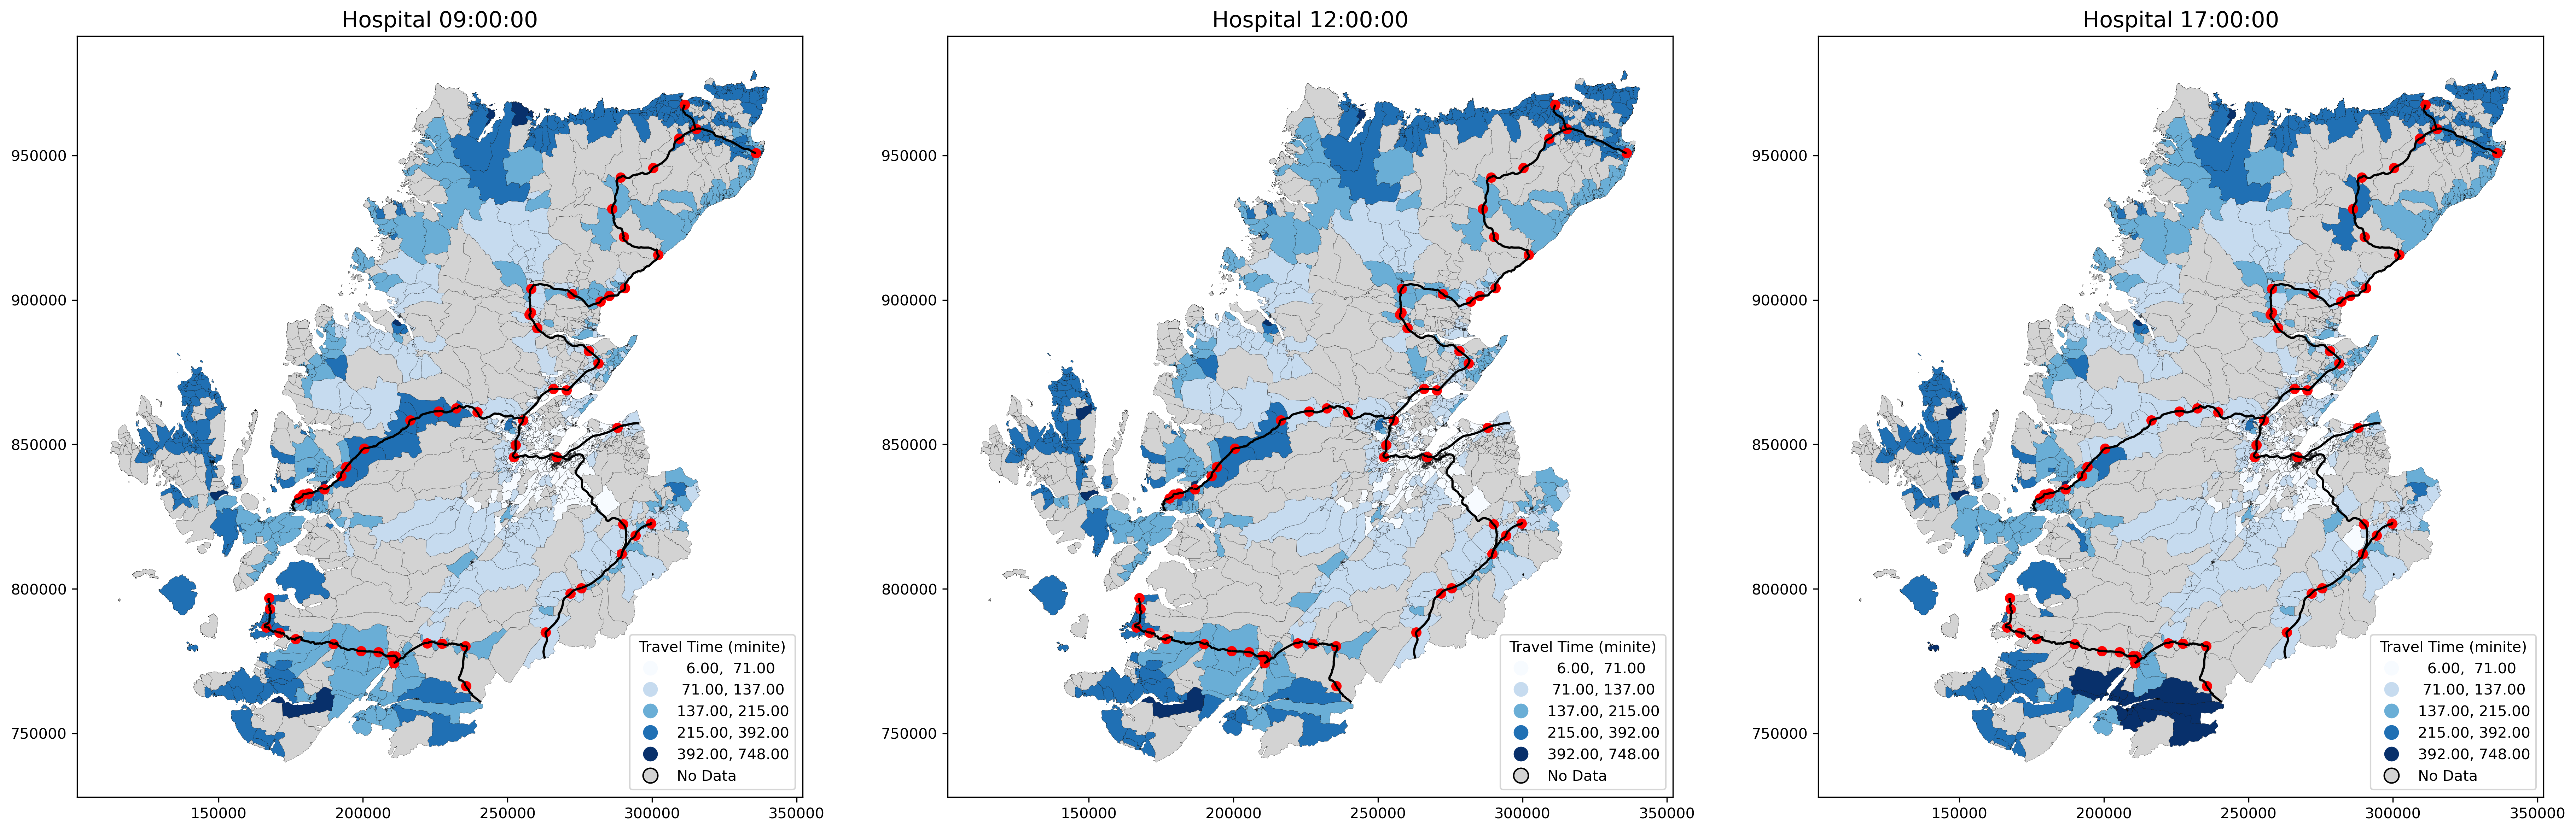

In [96]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10),dpi=300)
axs = axs.flatten()

for i in range(len(maps)):
    print(i)
    maps[i].plot(ax=axs[i], column='total_duration', cmap="Blues", 
                 legend=True,legend_kwds=({"loc":'lower right', 'title': 'Travel Time (minite)'}),
                 edgecolor = "black", lw = 0.1,
                 scheme='UserDefined',classification_kwds = {'bins':bins},
                 missing_kwds = dict(color='lightgray', label='No Data'))
    railway_station_highland.plot(color = 'red',ax=axs[i])
    railway_highland.plot(color = 'black',ax=axs[i])
    axs[i].set_title(times[i], size = 15)
#ctx.add_basemap(ax=axs[0], crs="EPSG:27700", source=ctx.providers.CartoDB.Positron)

fig.savefig('map_0804/hospital.png')

plt.show()

## Inverness travel time

In [103]:
postcode_polygon_highland

OBJECTID  postcode  HHcount  Popcount    council    Shape_Leng  \
0        20662   IV2 4SB       18        29  S12000017    347.757366   
1        20663   IV2 4TA       26        58  S12000017    835.144522   
2        20664  IV12 5SX       11        23  S12000017    902.309885   
3        20665  IV12 5SY       11        17  S12000017    291.531323   
4        20666   IV1 1LX        4         8  S12000017    308.716107   
...        ...       ...      ...       ...        ...           ...   
7003     57136  IV27 4RP       29        62  S12000017   7669.295119   
7004     57144  IV26 2TN        6        10  S12000017  18272.227682   
7005     57149  IV27 4SH        1         2  S12000017  32518.218520   
7006     57151   IV3 8AJ       39        80  S12000017   2870.266294   
7007     57744  PH38 4NG       15        25  S12000017  20556.713767   

        Shape_Area                                           geometry  
0     6.757492e+03  POLYGON ((266590.816 844148.409, 266578.597 84...  
1     3.884090e+04  POLYGON ((266655.000 844416.000, 266667.000 84...  
2     3.576943e+04  POLYGON ((292273.088 855635.043, 292245.000 85...  
3     3.271790e+03  POLYGON ((291993.267 855453.516, 291957.000 85...  
4     5.690192e+03  POLYGON ((266543.539 845556.845, 266518.564 84...  
...            ...                                                ...  
7003  9.785033e+05  POLYGON ((222130.494 956319.853, 222141.941 95...  
7004  3.943867e+06  MULTIPOLYGON (((212283.454 899872.261, 212248....  
7005  2.133881e+07  MULTIPOLYGON (((225307.527 952130.020, 226464....  
7006  3.940666e+05  POLYGON ((265445.200 847265.200, 265453.400 84...  
7007  8.921437e+06  MULTIPOLYGON (((166321.000 778173.500, 166330....  

[7008 rows x 8 columns]

### Travel iternary

In [108]:
airport_new.summary.iloc[0]

[('WALKING', 27),
 ('TRANSIT (BUS) 364', 17),
 ('WALKING', 0),
 ('TRANSIT (BUS) 37', 41),
 ('WALKING', 6),
 ('TRANSIT (HEAVY_RAIL) ScotRail', 37),
 ('WALKING', 2),
 ('TRANSIT (BUS) 11', 33),
 ('WALKING', 2)]